### IMPORT LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import backend as K
from tensorflow.keras.layers import MaxPooling2D

### IMPORT / VIEWING / PREPROCESSING DATASET

> `DATA AUGMENTATION`

In [2]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=30,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [3]:
train_dataset  = train_datagen.flow_from_directory(directory = './Alzheimer_s Dataset/train',
                                                   target_size = (150,150),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 128)

Found 4098 images belonging to 4 classes.


In [4]:
valid_dataset = valid_datagen.flow_from_directory(directory = './Alzheimer_s Dataset/train',
                                                  target_size = (150,150),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 128)

Found 1023 images belonging to 4 classes.


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.25s/it]


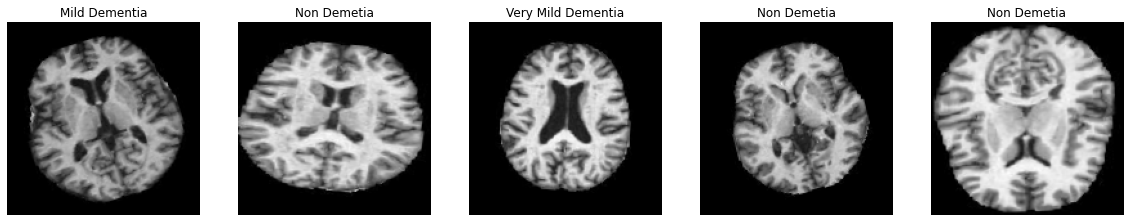

In [5]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize=(20,20))

for i in tqdm(range(0,5)):
    rand1 = np.random.randint(len(train_dataset))
    rand2 = np.random.randint(100)
    ax[i].imshow(train_dataset[rand1][0][rand2])
    ax[i].axis('off')
    a = train_dataset[rand1][1][rand2]
    if a[0] == 1:
        ax[i].set_title('Mild Dementia')
    elif a[1] == 1:
        ax[i].set_title('Moderate Dementia')
    elif a[2] == 1:
        ax[i].set_title('Non Demetia')
    elif a[3] == 1:
        ax[i].set_title('Very Mild Dementia')

### MODEL BUILDING

In [6]:
EPOCHS = 10
STEPS = 100
LR = 1e-3
BATCH_SIZE = 10
WIDTH = 150
HEIGHT = 150
DEPTH = 3

In [7]:

model = Sequential()
inputShape = (HEIGHT, WIDTH, DEPTH)
chanDim = -1



if K.image_data_format() == "channels_first":
    inputShape = (DEPTH, HEIGHT, WIDTH)
    chanDim = 1

model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(4))
model.add(Activation("softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 150, 150, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 50, 50, 64)        0

In [8]:
# Model Compile 

OPT    = tensorflow.keras.optimizers.Adam(lr=0.001)

model.compile(loss='categorical_crossentropy',
              metrics=[tensorflow.keras.metrics.AUC(name = 'auc')],
              optimizer=OPT)

In [9]:
# Defining Callbacks

filepath = './alz.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [11]:
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 10,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/10
33/33 [==============================] - 211s 7s/step - loss: 1.1513 - auc: 0.7876 - val_loss: 4.1811 - val_auc: 0.5663

Epoch 00001: val_auc did not improve from 0.78596
Epoch 2/10
33/33 [==============================] - 218s 7s/step - loss: 1.0786 - auc: 0.8040 - val_loss: 1.0478 - val_auc: 0.8176

Epoch 00002: val_auc improved from 0.78596 to 0.81760, saving model to .\alz.hdf5
Epoch 3/10
33/33 [==============================] - 204s 6s/step - loss: 1.0300 - auc: 0.8192 - val_loss: 1.9612 - val_auc: 0.7481

Epoch 00003: val_auc did not improve from 0.81760
Epoch 4/10
33/33 [==============================] - 213s 6s/step - loss: 1.0331 - auc: 0.8187 - val_loss: 1.1919 - val_auc: 0.8144

Epoch 00004: val_auc did not improve from 0.81760
Epoch 5/10
33/33 [==============================] - 218s 7s/step - loss: 1.0172 - auc: 0.8240 - val_loss: 1.5938 - val_auc: 0.7841

Epoch 00005: val_auc did not improve from 0.81760
Epoch 6/10
33/33 [==============================] - 218s 7

### MODEL EVALUATION

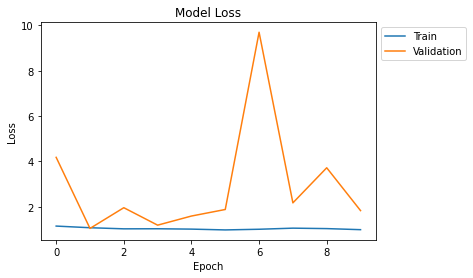

In [12]:
# Summarize history for loss

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

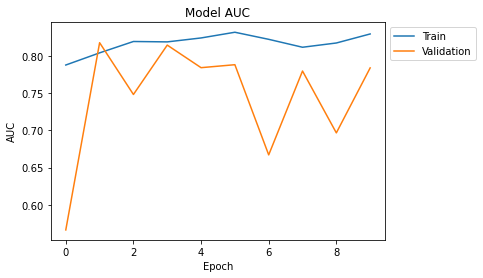

In [13]:
# Summarize history for loss

plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [14]:
# Test Data 

test_dataset  = test_datagen.flow_from_directory(directory = './Alzheimer_s Dataset/test',
                                                 target_size = (150,150),
                                                 class_mode = 'categorical',
                                                 batch_size = 128)

Found 1279 images belonging to 4 classes.


In [15]:
# Evaluating Loss and AUC

model.evaluate(test_dataset)

10/10 [==============================] - 12s 1s/step - loss: 1.8976 - auc: 0.7896


[1.8976339101791382, 0.7895802855491638]

 chances are there that the image is NORMAL


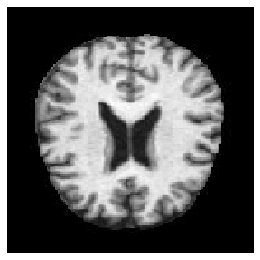

In [57]:
dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('./Alzheimer_s Dataset/test/NORMAL/26 (62).jpg', target_size = (150,150,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
#answer = model.predict_classes(img)
answer = np.argmax(model.predict(img))

print( ' chances are that the image is',idc[answer])

 chances are there that the image is VeryMild


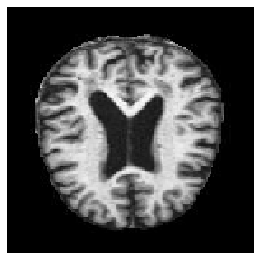

In [58]:
dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('./Alzheimer_s Dataset/test/VeryMild/26 (47).jpg', target_size = (150,150,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
#answer = model.predict_classes(img)
answer = np.argmax(model.predict(img))

print( ' chances are that the image is',idc[answer])